In [1]:
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import Counter
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import time
from tqdm import tqdm
import torch
import timm
import matplotlib.pyplot as plt
import copy
from torchvision.models import vit_b_16
from collections import Counter
from tqdm import tqdm # for progress bar
import random
import os

In [2]:
#drive.mount('/content/drive')

In [3]:
data_dir = '/kaggle/input/aav-spectrogram/spectrogram'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
# Test loading
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # Should be [B, C, 224, 224]

Batch shape: torch.Size([16, 3, 224, 224])


In [5]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

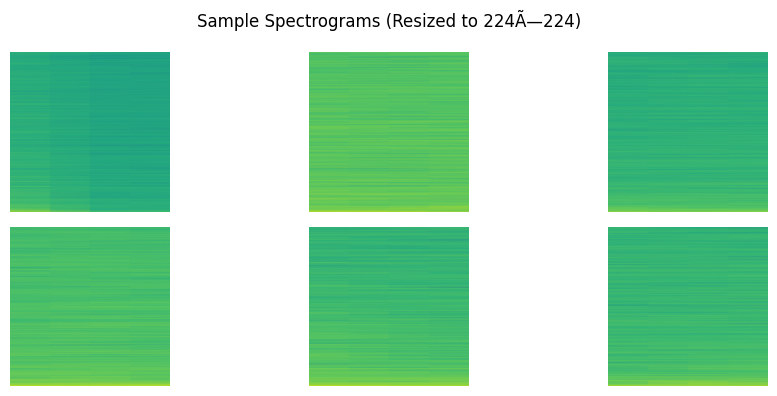

In [6]:
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample Spectrograms (Resized to 224Ã—224)")
plt.tight_layout()
plt.show()

In [7]:


def count_images_per_class(train_loader):
    """Counts the number of images per class in a train_loader.

    Args:
        train_loader: The DataLoader for the training dataset.

    Returns:
        A dictionary where keys are class labels and values are the corresponding counts.
    """

    all_labels = []
    for images, labels in tqdm(train_loader, desc="Counting images per class"):
        all_labels.extend(labels.tolist())  # Extend the list with labels from the batch

    class_counts = Counter(all_labels)  # Count occurrences of each label

    return class_counts

In [8]:
# Get the counts and print them
#class_counts = count_images_per_class(train_loader)

#print("Images per class in train_loader:")
#for class_label, count in class_counts.items():
#    print(f"Class {class_label}: {count} images")

In [9]:
# Get the counts and print them
#class_counts = count_images_per_class(val_loader)

#print("Images per class in train_loader:")
#for class_label, count in class_counts.items():
#    print(f"Class {class_label}: {count} images")

In [10]:
def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(context_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    
    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(target_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

In [11]:
class IJEPADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4):
        self.base_dataset = base_dataset
        self.context_scale = context_scale
        self.target_scale = target_scale
        self.num_targets = num_targets
        
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        context_block, target_blocks, _, _ = extract_blocks(image, self.context_scale, self.target_scale, self.num_targets)
        return context_block, target_blocks, label

In [12]:
train_ijepa_dataset = IJEPADataset(train_dataset)
val_ijepa_dataset   = IJEPADataset(val_dataset)


train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_ijepa_dataset, batch_size=32, shuffle=False)

In [13]:
def get_vit_encoder():
    model = vit_b_16(pretrained=False)
    model.heads = nn.Identity()  # remove classification head
    return model

In [14]:

context_encoder = get_vit_encoder().cuda()
target_encoder  = get_vit_encoder().cuda()
target_encoder.load_state_dict(context_encoder.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [15]:
class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)

In [16]:
# 6. Set up optimizer, loss, and EMA update (same as your CIFAR code).
predictor = Predictor().cuda()
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = nn.MSELoss()
ema_decay = 0.99

In [17]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)

In [18]:
# Create a directory for visualizations if it doesn't exist.
viz_dir = "/kaggle/working/viz"
os.makedirs(viz_dir, exist_ok=True)

num_epochs = 200
ema_decay = 0.99
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0
    
    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]
        
        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]
        
        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)
        
        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)
        
        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()
            
            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()
            
            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")
            
            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])
            
            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")
            
            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])
            
            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''
    
    epoch_loss = running_loss / len(train_ijepa_dataset)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.8f} - Epoch Time: {epoch_time:.2f}s")
    
    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, "/kaggle/working/ijepa_checkpoint_best.pth")
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")

total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

Epoch 1/200 - Train Loss: 0.05602617 - Epoch Time: 150.59s
Checkpoint saved at epoch 1 with loss 0.0560


Epoch 2/200 - Train Loss: 0.00047655 - Epoch Time: 143.83s
Checkpoint saved at epoch 2 with loss 0.0005


Epoch 3/200 - Train Loss: 0.00004318 - Epoch Time: 143.37s
Checkpoint saved at epoch 3 with loss 0.0000


Epoch 4/200 - Train Loss: 0.00038248 - Epoch Time: 143.40s


Epoch 5/200 - Train Loss: 0.00000160 - Epoch Time: 143.51s
Checkpoint saved at epoch 5 with loss 0.0000


Epoch 6/200 - Train Loss: 0.00040427 - Epoch Time: 143.74s


Epoch 7/200 - Train Loss: 0.00000166 - Epoch Time: 143.72s


Epoch 8/200 - Train Loss: 0.00000065 - Epoch Time: 143.75s
Checkpoint saved at epoch 8 with loss 0.0000


Epoch 9/200 - Train Loss: 0.00029942 - Epoch Time: 143.73s


Epoch 10/200 - Train Loss: 0.00000152 - Epoch Time: 143.51s


Epoch 11/200 - Train Loss: 0.00000064 - Epoch Time: 143.82s
Checkpoint saved at epoch 11 with loss 0.0000


Epoch 12/200 - Train Loss: 0.00026463 - Epoch Time: 143.61s


Epoch 13/200 - Train Loss: 0.00000273 - Epoch Time: 143.32s


Epoch 14/200 - Train Loss: 0.00000065 - Epoch Time: 143.37s


Epoch 15/200 - Train Loss: 0.00000996 - Epoch Time: 143.33s


Epoch 16/200 - Train Loss: 0.00027971 - Epoch Time: 143.44s


Epoch 17/200 - Train Loss: 0.00000073 - Epoch Time: 143.53s


Epoch 18/200 - Train Loss: 0.00000071 - Epoch Time: 143.58s


Epoch 19/200 - Train Loss: 0.00000077 - Epoch Time: 143.42s


Epoch 20/200 - Train Loss: 0.00021004 - Epoch Time: 144.07s


Epoch 21/200 - Train Loss: 0.00000085 - Epoch Time: 143.66s


Epoch 22/200 - Train Loss: 0.00000076 - Epoch Time: 143.53s


Epoch 23/200 - Train Loss: 0.00000082 - Epoch Time: 143.74s


Epoch 24/200 - Train Loss: 0.00017573 - Epoch Time: 143.45s


Epoch 25/200 - Train Loss: 0.00000086 - Epoch Time: 144.01s


Epoch 26/200 - Train Loss: 0.00000081 - Epoch Time: 143.53s


Epoch 27/200 - Train Loss: 0.00008390 - Epoch Time: 143.41s


Epoch 28/200 - Train Loss: 0.00010992 - Epoch Time: 143.84s


Epoch 29/200 - Train Loss: 0.00000076 - Epoch Time: 143.55s


Epoch 30/200 - Train Loss: 0.00011325 - Epoch Time: 143.93s


Epoch 31/200 - Train Loss: 0.00000574 - Epoch Time: 143.63s


Epoch 32/200 - Train Loss: 0.00000085 - Epoch Time: 143.40s


Epoch 33/200 - Train Loss: 0.00007778 - Epoch Time: 143.60s


Epoch 34/200 - Train Loss: 0.00001536 - Epoch Time: 143.66s


Epoch 35/200 - Train Loss: 0.00000115 - Epoch Time: 143.81s


Epoch 36/200 - Train Loss: 0.00010874 - Epoch Time: 143.93s


Epoch 37/200 - Train Loss: 0.00000173 - Epoch Time: 144.50s


Epoch 38/200 - Train Loss: 0.00002180 - Epoch Time: 144.01s


Epoch 39/200 - Train Loss: 0.00010987 - Epoch Time: 144.08s


Epoch 40/200 - Train Loss: 0.00000132 - Epoch Time: 144.16s


Epoch 41/200 - Train Loss: 0.00018210 - Epoch Time: 144.12s


Epoch 42/200 - Train Loss: 0.00061059 - Epoch Time: 144.17s


Epoch 43/200 - Train Loss: 0.00000074 - Epoch Time: 144.21s


Epoch 44/200 - Train Loss: 0.00000068 - Epoch Time: 143.99s


Epoch 45/200 - Train Loss: 0.00000070 - Epoch Time: 144.20s


Epoch 46/200 - Train Loss: 0.00000077 - Epoch Time: 144.38s


Epoch 47/200 - Train Loss: 0.00007700 - Epoch Time: 144.39s


Epoch 48/200 - Train Loss: 0.00000085 - Epoch Time: 144.41s


Epoch 49/200 - Train Loss: 0.00057324 - Epoch Time: 144.26s


Epoch 50/200 - Train Loss: 0.00073737 - Epoch Time: 145.56s


Epoch 51/200 - Train Loss: 0.00000051 - Epoch Time: 146.04s
Checkpoint saved at epoch 51 with loss 0.0000


Epoch 52/200 - Train Loss: 0.00000037 - Epoch Time: 145.53s
Checkpoint saved at epoch 52 with loss 0.0000


Epoch 53/200 - Train Loss: 0.00000035 - Epoch Time: 145.02s
Checkpoint saved at epoch 53 with loss 0.0000


Epoch 54/200 - Train Loss: 0.00000037 - Epoch Time: 145.09s


Epoch 55/200 - Train Loss: 0.00000037 - Epoch Time: 145.27s


Epoch 56/200 - Train Loss: 0.00000039 - Epoch Time: 145.22s


Epoch 57/200 - Train Loss: 0.00000043 - Epoch Time: 145.70s


Epoch 58/200 - Train Loss: 0.00000043 - Epoch Time: 145.37s


Epoch 59/200 - Train Loss: 0.00003896 - Epoch Time: 145.01s


Epoch 60/200 - Train Loss: 0.00002496 - Epoch Time: 145.21s


Epoch 61/200 - Train Loss: 0.00000703 - Epoch Time: 144.83s


Epoch 62/200 - Train Loss: 0.00000049 - Epoch Time: 144.49s


Epoch 63/200 - Train Loss: 0.00000052 - Epoch Time: 144.89s


Epoch 64/200 - Train Loss: 0.00004996 - Epoch Time: 145.15s


Epoch 65/200 - Train Loss: 0.00000055 - Epoch Time: 144.96s


Epoch 66/200 - Train Loss: 0.00000056 - Epoch Time: 145.40s


Epoch 67/200 - Train Loss: 0.00072034 - Epoch Time: 144.92s


Epoch 68/200 - Train Loss: 0.00091360 - Epoch Time: 145.01s


Epoch 69/200 - Train Loss: 0.00000024 - Epoch Time: 144.62s
Checkpoint saved at epoch 69 with loss 0.0000


Epoch 70/200 - Train Loss: 0.00000012 - Epoch Time: 144.52s
Checkpoint saved at epoch 70 with loss 0.0000


Epoch 71/200 - Train Loss: 0.00000011 - Epoch Time: 144.59s
Checkpoint saved at epoch 71 with loss 0.0000


Epoch 72/200 - Train Loss: 0.00000011 - Epoch Time: 145.19s
Checkpoint saved at epoch 72 with loss 0.0000


Epoch 73/200 - Train Loss: 0.00000011 - Epoch Time: 145.23s


Epoch 74/200 - Train Loss: 0.00000012 - Epoch Time: 145.43s


Epoch 75/200 - Train Loss: 0.00000012 - Epoch Time: 145.25s


Epoch 76/200 - Train Loss: 0.00000013 - Epoch Time: 144.20s


Epoch 77/200 - Train Loss: 0.00000014 - Epoch Time: 144.61s


Epoch 78/200 - Train Loss: 0.00000013 - Epoch Time: 143.90s


Epoch 79/200 - Train Loss: 0.00000013 - Epoch Time: 144.36s


Epoch 80/200 - Train Loss: 0.00000013 - Epoch Time: 144.66s


Epoch 81/200 - Train Loss: 0.00000013 - Epoch Time: 144.22s


Epoch 82/200 - Train Loss: 0.00001745 - Epoch Time: 144.43s


Epoch 83/200 - Train Loss: 0.00000020 - Epoch Time: 144.48s


Epoch 84/200 - Train Loss: 0.00000013 - Epoch Time: 144.64s


Epoch 85/200 - Train Loss: 0.00000015 - Epoch Time: 144.72s


Epoch 86/200 - Train Loss: 0.00000015 - Epoch Time: 144.32s


Epoch 87/200 - Train Loss: 0.00006263 - Epoch Time: 144.41s


Epoch 88/200 - Train Loss: 0.00000269 - Epoch Time: 144.58s


Epoch 89/200 - Train Loss: 0.00001891 - Epoch Time: 144.87s


Epoch 90/200 - Train Loss: 0.00000020 - Epoch Time: 144.42s


Epoch 91/200 - Train Loss: 0.00000438 - Epoch Time: 144.54s


Epoch 92/200 - Train Loss: 0.00000373 - Epoch Time: 144.90s


Epoch 93/200 - Train Loss: 0.00002257 - Epoch Time: 144.87s


Epoch 94/200 - Train Loss: 0.00000909 - Epoch Time: 144.95s


Epoch 95/200 - Train Loss: 0.00002099 - Epoch Time: 144.61s


Epoch 96/200 - Train Loss: 0.00175968 - Epoch Time: 145.46s


Epoch 97/200 - Train Loss: 0.00000271 - Epoch Time: 148.30s


Epoch 98/200 - Train Loss: 0.00000005 - Epoch Time: 150.39s
Checkpoint saved at epoch 98 with loss 0.0000


Epoch 99/200 - Train Loss: 0.00000005 - Epoch Time: 149.97s
Checkpoint saved at epoch 99 with loss 0.0000


Epoch 100/200 - Train Loss: 0.00000005 - Epoch Time: 150.33s
Checkpoint saved at epoch 100 with loss 0.0000


Epoch 101/200 - Train Loss: 0.00000005 - Epoch Time: 149.65s


Epoch 102/200 - Train Loss: 0.00000005 - Epoch Time: 150.03s


Epoch 103/200 - Train Loss: 0.00000005 - Epoch Time: 149.26s


Epoch 104/200 - Train Loss: 0.00000005 - Epoch Time: 149.12s


Epoch 105/200 - Train Loss: 0.00000005 - Epoch Time: 149.51s


Epoch 106/200 - Train Loss: 0.00000005 - Epoch Time: 150.03s


Epoch 107/200 - Train Loss: 0.00000006 - Epoch Time: 147.15s


Epoch 108/200 - Train Loss: 0.00000005 - Epoch Time: 149.02s


Epoch 109/200 - Train Loss: 0.00000006 - Epoch Time: 145.13s


Epoch 110/200 - Train Loss: 0.00000006 - Epoch Time: 145.29s


Epoch 111/200 - Train Loss: 0.00000006 - Epoch Time: 145.36s


Epoch 112/200 - Train Loss: 0.00000006 - Epoch Time: 145.95s


Epoch 113/200 - Train Loss: 0.00001390 - Epoch Time: 145.31s


Epoch 114/200 - Train Loss: 0.00000007 - Epoch Time: 145.90s


Epoch 115/200 - Train Loss: 0.00000006 - Epoch Time: 145.33s


Epoch 116/200 - Train Loss: 0.00000007 - Epoch Time: 144.73s


Epoch 117/200 - Train Loss: 0.00000007 - Epoch Time: 144.63s


Epoch 118/200 - Train Loss: 0.00000008 - Epoch Time: 144.45s


Epoch 119/200 - Train Loss: 0.00006802 - Epoch Time: 144.25s


Epoch 120/200 - Train Loss: 0.00000025 - Epoch Time: 144.49s


Epoch 121/200 - Train Loss: 0.00001282 - Epoch Time: 144.42s


Epoch 122/200 - Train Loss: 0.00000007 - Epoch Time: 144.07s


Epoch 123/200 - Train Loss: 0.00000008 - Epoch Time: 144.37s


Epoch 124/200 - Train Loss: 0.00000009 - Epoch Time: 144.45s


Epoch 125/200 - Train Loss: 0.00001400 - Epoch Time: 144.17s


Epoch 126/200 - Train Loss: 0.00000285 - Epoch Time: 144.13s


Epoch 127/200 - Train Loss: 0.00000299 - Epoch Time: 144.50s


Epoch 128/200 - Train Loss: 0.00001202 - Epoch Time: 144.27s


Epoch 129/200 - Train Loss: 0.00000979 - Epoch Time: 144.40s


Epoch 130/200 - Train Loss: 0.00000949 - Epoch Time: 144.12s


Epoch 131/200 - Train Loss: 0.00001286 - Epoch Time: 144.14s


Epoch 132/200 - Train Loss: 0.00001007 - Epoch Time: 144.14s


Epoch 133/200 - Train Loss: 0.00001749 - Epoch Time: 144.23s


Epoch 134/200 - Train Loss: 0.00001222 - Epoch Time: 144.80s


Epoch 135/200 - Train Loss: 0.00033536 - Epoch Time: 144.59s


Epoch 136/200 - Train Loss: 0.00002530 - Epoch Time: 144.65s


Epoch 137/200 - Train Loss: 0.00000006 - Epoch Time: 144.64s


Epoch 138/200 - Train Loss: 0.00000006 - Epoch Time: 145.04s


Epoch 139/200 - Train Loss: 0.00000407 - Epoch Time: 144.87s


Epoch 140/200 - Train Loss: 0.00000008 - Epoch Time: 144.27s


Epoch 141/200 - Train Loss: 0.00000006 - Epoch Time: 144.41s


Epoch 142/200 - Train Loss: 0.00000006 - Epoch Time: 144.85s


Epoch 143/200 - Train Loss: 0.00000006 - Epoch Time: 144.53s


Epoch 144/200 - Train Loss: 0.00000584 - Epoch Time: 144.83s


Epoch 145/200 - Train Loss: 0.00000009 - Epoch Time: 144.31s


Epoch 146/200 - Train Loss: 0.00000007 - Epoch Time: 144.40s


Epoch 147/200 - Train Loss: 0.00000008 - Epoch Time: 144.50s


Epoch 148/200 - Train Loss: 0.00003889 - Epoch Time: 144.70s


Epoch 149/200 - Train Loss: 0.00000040 - Epoch Time: 144.58s


Epoch 150/200 - Train Loss: 0.00000008 - Epoch Time: 144.69s


Epoch 151/200 - Train Loss: 0.00000704 - Epoch Time: 144.51s


Epoch 152/200 - Train Loss: 0.00002867 - Epoch Time: 144.56s


Epoch 153/200 - Train Loss: 0.00000049 - Epoch Time: 144.41s


Epoch 154/200 - Train Loss: 0.00000416 - Epoch Time: 144.14s


Epoch 155/200 - Train Loss: 0.00000388 - Epoch Time: 144.71s


Epoch 156/200 - Train Loss: 0.00000453 - Epoch Time: 144.56s


Epoch 157/200 - Train Loss: 0.00001584 - Epoch Time: 144.81s


Epoch 158/200 - Train Loss: 0.00000305 - Epoch Time: 144.71s


Epoch 159/200 - Train Loss: 0.00109819 - Epoch Time: 145.23s


Epoch 160/200 - Train Loss: 0.00000100 - Epoch Time: 144.81s


Epoch 161/200 - Train Loss: 0.00000002 - Epoch Time: 144.67s
Checkpoint saved at epoch 161 with loss 0.0000


Epoch 162/200 - Train Loss: 0.00000002 - Epoch Time: 145.13s
Checkpoint saved at epoch 162 with loss 0.0000


Epoch 163/200 - Train Loss: 0.00000002 - Epoch Time: 145.17s
Checkpoint saved at epoch 163 with loss 0.0000


Epoch 164/200 - Train Loss: 0.00000002 - Epoch Time: 145.16s


Epoch 165/200 - Train Loss: 0.00000002 - Epoch Time: 144.46s


Epoch 166/200 - Train Loss: 0.00000002 - Epoch Time: 144.69s


Epoch 167/200 - Train Loss: 0.00000002 - Epoch Time: 144.69s


Epoch 168/200 - Train Loss: 0.00000002 - Epoch Time: 143.94s


Epoch 169/200 - Train Loss: 0.00000002 - Epoch Time: 144.11s


Epoch 170/200 - Train Loss: 0.00000002 - Epoch Time: 143.96s


Epoch 171/200 - Train Loss: 0.00000002 - Epoch Time: 144.84s


Epoch 172/200 - Train Loss: 0.00000002 - Epoch Time: 144.32s


Epoch 173/200 - Train Loss: 0.00000002 - Epoch Time: 144.08s


Epoch 174/200 - Train Loss: 0.00000002 - Epoch Time: 144.17s


Epoch 175/200 - Train Loss: 0.00000002 - Epoch Time: 143.46s


Epoch 176/200 - Train Loss: 0.00000002 - Epoch Time: 144.56s


Epoch 177/200 - Train Loss: 0.00000003 - Epoch Time: 144.54s


Epoch 178/200 - Train Loss: 0.00000004 - Epoch Time: 144.48s


Epoch 179/200 - Train Loss: 0.00000008 - Epoch Time: 144.19s


Epoch 180/200 - Train Loss: 0.00000013 - Epoch Time: 144.13s


Epoch 181/200 - Train Loss: 0.00000022 - Epoch Time: 144.39s


Epoch 182/200 - Train Loss: 0.00000047 - Epoch Time: 143.75s


Epoch 183/200 - Train Loss: 0.00000114 - Epoch Time: 144.11s


Epoch 184/200 - Train Loss: 0.00000215 - Epoch Time: 143.76s


Epoch 185/200 - Train Loss: 0.00000429 - Epoch Time: 143.94s


Epoch 186/200 - Train Loss: 0.00000630 - Epoch Time: 143.84s


Epoch 187/200 - Train Loss: 0.00000225 - Epoch Time: 143.90s


Epoch 188/200 - Train Loss: 0.00000292 - Epoch Time: 144.40s


Epoch 189/200 - Train Loss: 0.00000624 - Epoch Time: 143.78s


Epoch 190/200 - Train Loss: 0.00000421 - Epoch Time: 143.87s


Epoch 191/200 - Train Loss: 0.00004297 - Epoch Time: 144.13s


Epoch 192/200 - Train Loss: 0.00000099 - Epoch Time: 143.87s


Epoch 193/200 - Train Loss: 0.00000003 - Epoch Time: 143.93s


Epoch 194/200 - Train Loss: 0.00001186 - Epoch Time: 144.15s


Epoch 195/200 - Train Loss: 0.00000012 - Epoch Time: 144.00s


Epoch 196/200 - Train Loss: 0.00000202 - Epoch Time: 144.48s


Epoch 197/200 - Train Loss: 0.00000520 - Epoch Time: 143.91s


Epoch 198/200 - Train Loss: 0.00000542 - Epoch Time: 143.89s


Epoch 199/200 - Train Loss: 0.00000598 - Epoch Time: 144.29s


Epoch 200/200 - Train Loss: 0.00000957 - Epoch Time: 143.92s
Total Training Time: 29003.24s
